In [1]:
import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# gnn.py 

import sys
import math
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F

# Whether use adjoint method or not.
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


# Define the ODE function.
# Input:
# --- t: A tensor with shape [], meaning the current time.
# --- x: A tensor with shape [#batches, dims], meaning the value of x at t.
# Output:
# --- dx/dt: A tensor with shape [#batches, dims], meaning the derivative of x at t.
class ODEFunc(nn.Module):

    # currently requires in_features = out_features
    def __init__(self, in_features, out_features, opt, adj, deg):
        super(ODEFunc, self).__init__()
        self.opt = opt
        self.adj = adj
        self.x0 = None
        self.nfe = 0
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = opt['alpha']
        self.alpha_train = nn.Parameter(self.alpha*torch.ones(adj.shape[1]))

        self.w = nn.Parameter(torch.eye(opt['hidden_dim']))
        self.d = nn.Parameter(torch.zeros(opt['hidden_dim']) + 1)

    def forward(self, t, x):
        self.nfe +=1

        alph = F.sigmoid(self.alpha_train).unsqueeze(dim=1)
        ax = torch.spmm(self.adj, x)
        f = alph * 0.5 * (ax-x) + self.x0
        return f



class ODEblock(nn.Module):
    def __init__(self, odefunc, t=torch.tensor([0,1])):
        super(ODEblock, self).__init__()
        self.t = t
        self.odefunc = odefunc
        self.nfe = 0

    def set_x0(self, x0):
        self.odefunc.x0 = x0.clone().detach()

    def forward(self, x):
        self.nfe += 1

        t = self.t.type_as(x)
        z = odeint(self.odefunc, x, t)[1]
        return z

    def __repr__(self):
        return self.__class__.__name__ + '( Time Interval ' + str(self.t[0].item()) + ' -> ' + str(self.t[1].item()) \
               + ")"


# Define the GNN model.
class GNN(nn.Module):
    def __init__(self, opt, adj, deg, time,  m1_params=None, m2_params=None):
        super(GNN, self).__init__()
        self.opt = opt
        self.adj = adj
        self.T = time

        self.m1 = nn.Sequential(nn.Linear(opt['num_feature'], opt['hidden_dim']), nn.ReLU())

        self.odeblock = ODEblock(ODEFunc(2*opt['hidden_dim'], 2*opt['hidden_dim'], opt, adj, deg), t=torch.tensor([0,self.T]))

        self.m2 = nn.Sequential(
                nn.Linear(opt['hidden_dim'], opt['num_class']),
                nn.Identity())
        
        self.m1_params = m1_params
        self.m2_params = m2_params

        if opt['cuda']:
            self.cuda()

    def reset(self):
        
        # we set linear-layer WGNN parameters to those fed in.
        if self.m1_params is None:
            self.m1.reset_parameters()
        else:
            self.m1[0].weight.data = m1_params['weight']
            self.m1[0].bias.data = m1_params['bias']
        
        # ----------------------------------------------
        if self.m2_params is None:
            self.m2.reset_parameters()
        else:
            self.m2[0].weight.data = m2_params['weight']
            self.m2[0].bias.data = m2_params['bias']

    def forward(self, x):
        # Encode each node based on its feature.
        x = F.dropout(x, self.opt['input_dropout'], training=self.training)
        x = self.m1(x)

        # Solve the initial value problem of the ODE.
        c_aux = torch.zeros(x.shape, device=x.device)
        x = torch.cat([x,c_aux], dim=1)
        self.odeblock.set_x0(x)

        z = self.odeblock(x)
        z = torch.split(z, x.shape[1]//2, dim=1)[0]

        # Activation.
        z = F.relu(z)

        # Dropout.
        z = F.dropout(z, self.opt['dropout'], training=self.training)
        
        # global mean agg
        z = z.mean(axis=0)

        # Decode each node embedding to get node label.
        z = self.m2(z)
        return z

In [3]:
# wgnn.py 

import sys
import math
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F

# Whether use adjoint method or not.
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


# Define the ODE function.
# Input:
# --- t: A tensor with shape [], meaning the current time.
# --- x: A tensor with shape [#batches, dims], meaning the value of x at t.
# Output:
# --- dx/dt: A tensor with shape [#batches, dims], meaning the derivative of x at t.
class ODEFuncW(nn.Module):

    # currently requires in_features = out_features
    def __init__(self, in_features, out_features, opt, adj, deg):
        super(ODEFuncW, self).__init__()
        self.opt = opt
        self.adj = adj
        self.x0 = None
        self.nfe = 0
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = opt['alpha']
        self.alpha_train = nn.Parameter(self.alpha*torch.ones(adj.shape[1]))

        self.w = nn.Parameter(torch.eye(2*opt['hidden_dim']))
        self.d = nn.Parameter(torch.zeros(2*opt['hidden_dim']) + 1)

    def forward(self, t, x):
        self.nfe +=1

        alph = F.sigmoid(self.alpha_train).unsqueeze(dim=1)
        ax = torch.spmm(self.adj, x)
        
        d = torch.clamp(self.d, min=0, max=1)
        w = torch.mm(self.w * d, torch.t(self.w))
        xw = torch.spmm(x, w)
        
        f = alph * 0.5 * (ax - x) + xw - x + self.x0

        return f



class ODEblockW(nn.Module):
    def __init__(self, odefunc, t=torch.tensor([0,1])):
        super(ODEblockW, self).__init__()
        self.t = t
        self.odefunc = odefunc
        self.nfe = 0

    def set_x0(self, x0):
        self.odefunc.x0 = x0.clone().detach()

    def forward(self, x):
        self.nfe += 1

        t = self.t.type_as(x)
        z = odeint(self.odefunc, x, t)[1]
        return z

    def __repr__(self):
        return self.__class__.__name__ + '( Time Interval ' + str(self.t[0].item()) + ' -> ' + str(self.t[1].item()) \
               + ")"


# Define the GNN model.
class WGNN(nn.Module):
    def __init__(self, opt, adj, deg, time, m1_params=None, m2_params=None):
        super(WGNN, self).__init__()
        self.opt = opt
        self.adj = adj
        self.T = time

        self.m1 = nn.Sequential(nn.Linear(opt['num_feature'], opt['hidden_dim']), nn.ReLU())

        self.odeblock = ODEblockW(ODEFuncW(2*opt['hidden_dim'], 2*opt['hidden_dim'], opt, adj, deg), t=torch.tensor([0,self.T]))

        self.m2 = nn.Sequential(
                nn.Linear(opt['hidden_dim'], opt['num_class']),
                nn.Identity())
        
        self.m1_params = m1_params
        self.m2_params = m2_params
        

        if opt['cuda']:
            self.cuda()

    def reset(self):
        
        # we set linear-layer WGNN parameters to those fed in.
        if self.m1_params is None:
            self.m1.reset_parameters()
        else:
            self.m1[0].weight.data = m1_params['weight']
            self.m1[0].bias.data = m1_params['bias']
        
        # ----------------------------------------------
        if self.m2_params is None:
            self.m2.reset_parameters()
        else:
            self.m2[0].weight.data = m2_params['weight']
            self.m2[0].bias.data = m2_params['bias']
        

    def forward(self, x):
        # Encode each node based on its feature.
        x = F.dropout(x, self.opt['input_dropout'], training=self.training)
        x = self.m1(x)

        # Solve the initial value problem of the ODE.
        c_aux = torch.zeros(x.shape, device=x.device)
        x = torch.cat([x,c_aux], dim=1)
        self.odeblock.set_x0(x)

        z = self.odeblock(x)
        z = torch.split(z, x.shape[1]//2, dim=1)[0]

        # Activation.
        z = F.relu(z)

        # Dropout.
        z = F.dropout(z, self.opt['dropout'], training=self.training)
        
        # we need to mean aggregate globally across all the node features
        z = z.mean(axis=0)

        # Apply through softmax layer
        z = self.m2(z)
        
        return z

In [4]:
# trainer.py

import math
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Optimizer

def get_optimizer(name, parameters, lr, weight_decay=0):
    if name == 'sgd':
        return torch.optim.SGD(parameters, lr=lr, weight_decay=weight_decay)
    elif name == 'rmsprop':
        return torch.optim.RMSprop(parameters, lr=lr, weight_decay=weight_decay)
    elif name == 'adagrad':
        return torch.optim.Adagrad(parameters, lr=lr, weight_decay=weight_decay)
    elif name == 'adam':
        return torch.optim.Adam(parameters, lr=lr, weight_decay=weight_decay)
    elif name == 'adamax':
        return torch.optim.Adamax(parameters, lr=lr, weight_decay=weight_decay)
    else:
        raise Exception("Unsupported optimizer: {}".format(name))

# Counter of forward and backward passes.
class Meter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = None
        self.sum = 0
        self.cnt = 0

    def update(self, val):
        self.val = val
        self.sum += val
        self.cnt += 1

    def get_average(self):
        if self.cnt == 0:
            return 0
        return self.sum / self.cnt

    def get_value(self):
        return self.val

class Trainer(object):
    def __init__(self, opt, model):
        self.opt = opt
        self.model = model
        self.fm = Meter()
        self.bm = Meter()
        self.criterion = nn.CrossEntropyLoss()
        self.parameters = [p for p in self.model.parameters() if p.requires_grad]
        if opt['cuda']:
            self.criterion.cuda()
        self.optimizer = get_optimizer(self.opt['optimizer'], self.parameters, self.opt['lr'], self.opt['decay'])

    def reset(self):
        self.model.reset()
        self.optimizer = get_optimizer(self.opt['optimizer'], self.parameters, self.opt['lr'], self.opt['decay'])

    

    def predict(self, inputs, tau=1):
        if self.opt['cuda']:
            inputs = inputs.cuda()

        self.model.eval()

        logits = self.model(inputs)
        logits = torch.softmax(logits, dim=-1).detach()

        return logits

# CORA CGNN

In [5]:
import sys
import os
import copy
import json
import datetime

opt = dict()

opt['input_dropout'] = 0
opt['dropout'] = 0
opt['optimizer'] = 'rmsprop'
opt['lr'] = 0.0047
opt['decay'] = 5e-4
opt['self_link_weight'] = 1
opt['alpha'] = 0.918
opt['epoch'] = 10


In [6]:
#!/usr/bin/env python3
import copy
import numpy as np
import random
import argparse
import statistics
import torch




In [7]:
import networkx as nx

In [278]:
def generate_random_graph(random_graph_model, n, graph_params):
    """
    Generate an undirected graph using a random graph model from (ER, BA, SmallWorld) with NetworkX.
    Returns adjacency matrices and degree tensor as PyTorch tensors.
    """
    # Generate an Erdos-Renyi graph

    if random_graph_model == 'ER':
        # here we use the logarithmic growth assumption with K=1
        p = np.log(n)/n
        graph = nx.erdos_renyi_graph(n, p)
        
    if random_graph_model == 'BA':
        m = graph_params
        graph = nx.barabasi_albert_graph(n, m)
        
    if random_graph_model == 'WS':
        k, p = graph_params
        graph = nx.watts_strogatz_graph(n, k, p)
        
    #nx.draw(graph)
    #plt.show()
    # Compute the adjacency matrix as a NumPy array
    adjacency_matrix = nx.to_numpy_array(graph)
    
    # Compute degrees
    degrees = np.sum(adjacency_matrix, axis=1) 
    d_inv_sqrt = 1 / np.sqrt(degrees)
    d_inv_sqrt = np.nan_to_num(d_inv_sqrt, nan=0, posinf=0)
    D = np.diag(d_inv_sqrt)
    
    normalized_adjacency = np.eye(n) + D@adjacency_matrix@D
    
    # Convert everything to PyTorch tensors
    adjacency_matrix_torch = torch.tensor(adjacency_matrix, dtype=torch.float32)
    normalized_adjacency_torch = torch.tensor(normalized_adjacency, dtype=torch.float32)
    degree_tensor_torch = torch.tensor(degrees, dtype=torch.float32)
    
    return normalized_adjacency_torch, adjacency_matrix_torch, degree_tensor_torch
    


In [271]:
from tqdm import tqdm

In [272]:
# set device
opt['cuda'] = False



device = torch.device('cuda' if opt['cuda'] == True and torch.cuda.is_available() else 'cpu')

#--------------------------------------------------
# Load data.
#--------------------------------------------------

opt['num_feature'] = 128
opt['num_class'] = 4
opt['hidden_dim'] = 32

sigma=0.05
mu=0


# Randomly generate parameters for encoding and decoding NNs in CGNN
# m1_params = {}
# m1_params['weight'] = (sigma*torch.randn(opt['hidden_dim'], opt['num_feature'])) + mu
# m1_params['bias'] = (sigma*torch.randn(opt['hidden_dim'])) + mu

# m2_params = {}
# m2_params['weight'] = (sigma*torch.randn(opt['num_class'], opt['hidden_dim'])) + mu
# m2_params['bias'] = (sigma*torch.randn(opt['num_class'])) + mu
#--------------------------------------------------
# do reset() to initialise model with generated params
#--------------------------------------------------

In [273]:
# code to save and load m1,m2 params for repeatability

# import pickle

# saved_params = (m1_params, m2_params)

# with open("saved_params_m1_m2.pkl", "wb") as file:
#     pickle.dump(saved_params, file)

In [274]:
# Load the object from the file
with open("saved_params_m1_m2.pkl", "rb") as file:
    m1_params, m2_params = pickle.load(file)

print("params loaded.")

params loaded.


In [315]:
def ConvergenceStudy(n_values, opt, m1_params, m2_params, random_graph_model, random_graph_params):
    print(n_values)
    
    mean_densities_list = []
    std_densities_list = []

    for n in tqdm(n_values):
        #print(f'n={n}')

        opt['num_node'] = n

        pred_list = []
        for i in range(50):
            # Generate the graph and normalized adjacency matrix
            normalized_adjacency, adjacency_matrix, degree_tensor = generate_random_graph(random_graph_model, n, random_graph_params)

            if opt['weight']:
                gnn = WGNN(opt, normalized_adjacency, degree_tensor, opt['time'], m1_params=m1_params, m2_params=m2_params)
                gnn.reset()
            else:
                gnn = GNN(opt, normalized_adjacency, degree_tensor, opt['time'], m1_params=m1_params, m2_params=m2_params)
                gnn.reset()


            # generate random node features U(a,b)
            a, b = 0, 1
            inputs = torch.rand(opt['num_node'], opt['num_feature'])*(b-a) + a 
            target = torch.randint(low=1, high=opt['num_class'], size=(opt['num_node'],))

            if opt['cuda']:
                inputs = inputs.cuda()
                target = target.cuda()

            trainer = Trainer(opt, gnn)
            pred = trainer.predict(inputs, target)

            pred_list.append(pred)

        distributions = torch.stack(pred_list)
        mean_dist = distributions.mean(axis=0)
        std_dist = distributions.std(axis=0)

        mean_densities_list.append(mean_dist)
        std_densities_list.append(std_dist)



    mean_densities_tensor = torch.stack(mean_densities_list)
    std_densities_tensor = torch.stack(std_densities_list)

    return mean_densities_tensor, std_densities_tensor

In [316]:
def visualise_mean_class_probability_and_std(mean_densities_tensor, std_densities_tensor, title=''):
    
    plt.rcParams.update({
    'axes.titlesize': 18,       # Title font size
    'axes.labelsize': 18,       # X and Y labels font size
    'xtick.labelsize': 12,      # X-axis tick labels font size
    'ytick.labelsize': 12,      # Y-axis tick labels font size
    'legend.fontsize': 12,      # Legend font size
    'figure.titlesize': 20      # Figure title font size
    })

    # Plot each column as a separate line

    plt.figure(figsize=(7, 7))
    plt.grid(True, color='grey')  # Enable gridlines


    for col in range(mean_densities_tensor.shape[1]):

        y_values = mean_densities_tensor[:, col]  # Extract the column
        y_err = std_densities_tensor[:, col]

        plt.plot(n_values, y_values, label=f"Class {col+1}", marker='x')
         # Add shaded error bars
        plt.fill_between(
            n_values,
             y_values - y_err,  # Lower bound
            y_values + y_err,  # Upper bound
            alpha=0.2  # Transparency for the shading
        )

    # Add labels and legend
    plt.xlabel('Graph order (n)')
    plt.ylabel('Mean ($z̄_n$)')

    plt.xscale('log')
    plt.title(title)
    plt.show()
    
    plt.figure(figsize=(7, 7))

    for col in range(std_densities_tensor.shape[1]):
        # we express the standard deviation as a % of the mean
        y_rel_err = 100*(std_densities_tensor[:, col]/mean_densities_tensor[:, col])

        plt.plot(n_values, y_rel_err, label=f"Class {col+1}")

    # Add labels and legend
    plt.xlabel('Graph order (n)')
    plt.ylabel('Relative Standard deviation (%)')

    plt.xscale('log')
    plt.title(title)

    plt.show()
    
    plt.figure(figsize=(7, 7))

    for col in range(std_densities_tensor.shape[1]):
        # we express the standard deviation as a % of the mean
        y_err = std_densities_tensor[:, col]

        plt.plot(n_values, y_err, label=f"Class {col+1}")

    # Add labels and legend
    plt.xlabel('Graph order (n)')
    plt.ylabel('Standard deviation ($\sigma_{z_n}$)')

    plt.xscale('log')
    plt.title(title)
    plt.show()

# Non-weighted CGNN simulations; t=1

[10, 15, 23, 34, 52, 78, 118, 178, 268, 405, 611, 921, 1389, 2096, 3162]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:21<00:00, 25.42s/it]


WS t=1 ----------------------------------------------------------------------------------------------------


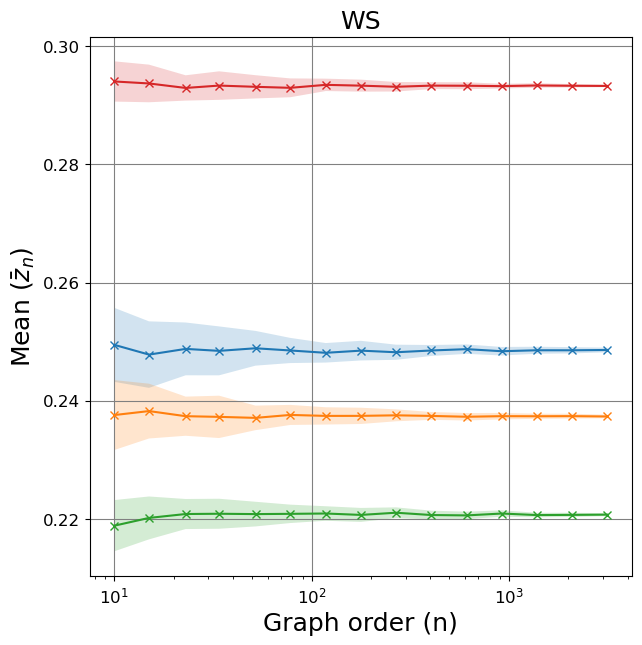

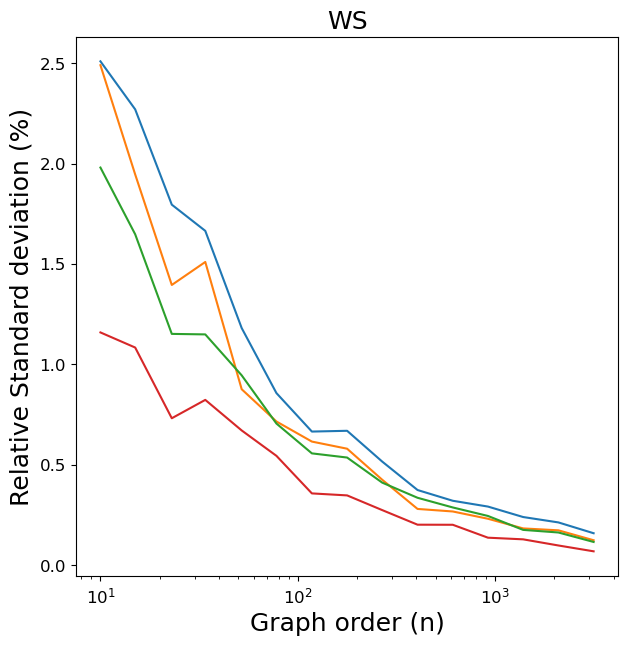

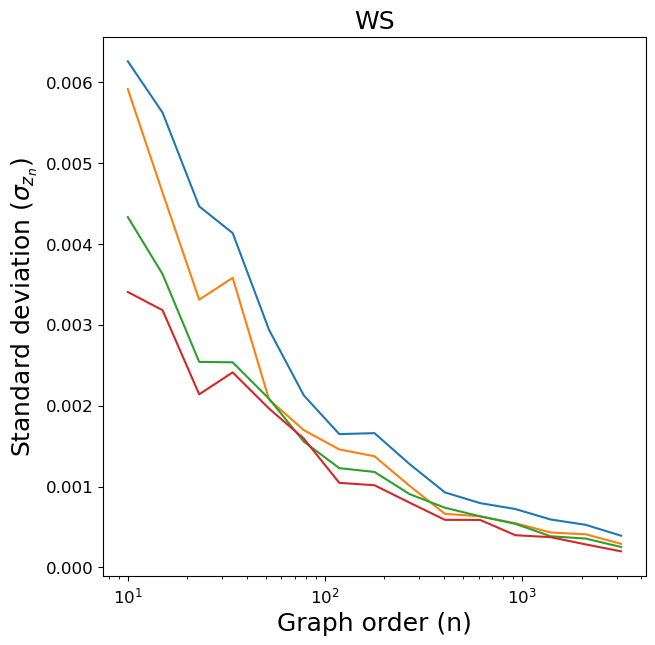

[10, 15, 23, 34, 52, 78, 118, 178, 268, 405, 611, 921, 1389, 2096, 3162]


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]C:\Users\prane\AppData\Local\Temp\ipykernel_16672\3406047335.py:28: RuntimeWarning: divide by zero encountered in divide
  d_inv_sqrt = 1 / np.sqrt(degrees)
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:01<00:00, 32.12s/it]


ER t=1 ----------------------------------------------------------------------------------------------------


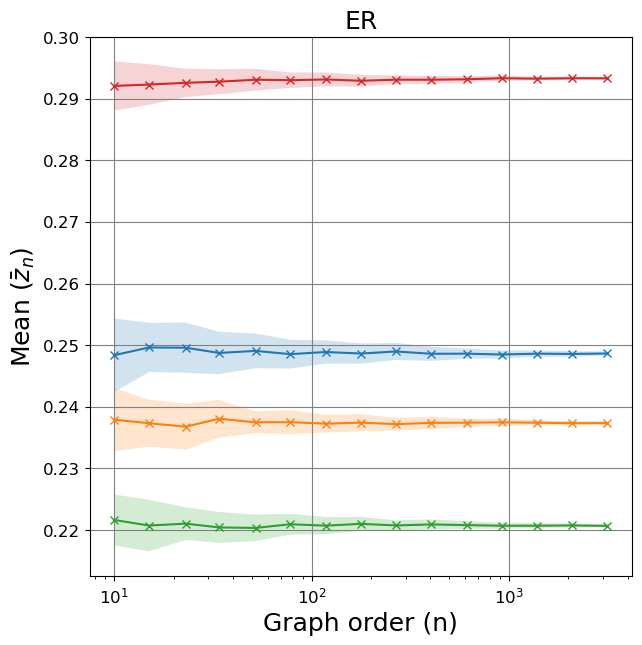

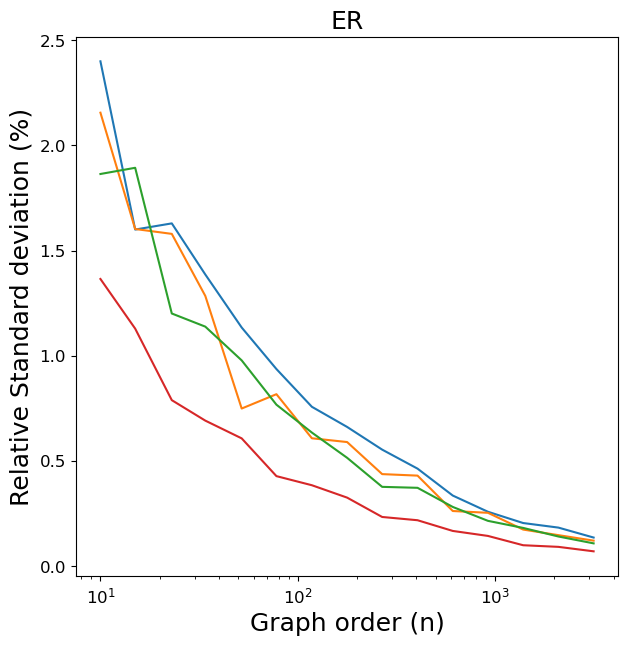

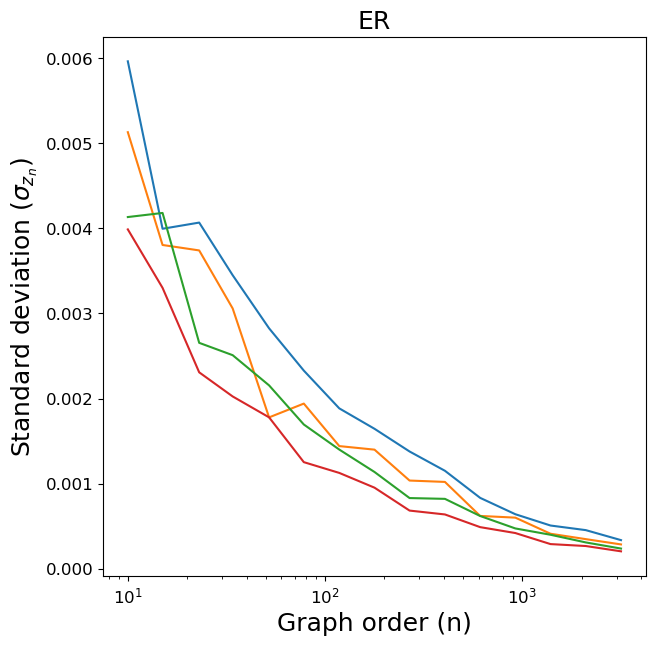

[10, 15, 23, 34, 52, 78, 118, 178, 268, 405, 611, 921, 1389, 2096, 3162]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:25<00:00, 25.71s/it]


BA t=1 ----------------------------------------------------------------------------------------------------


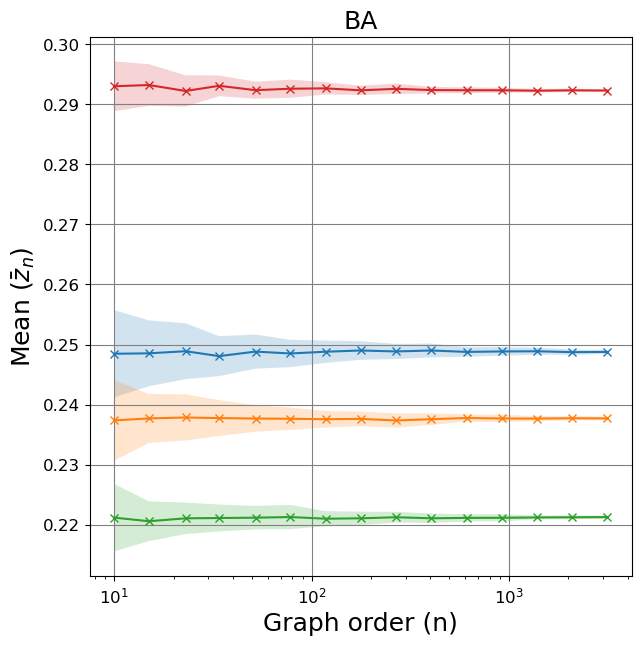

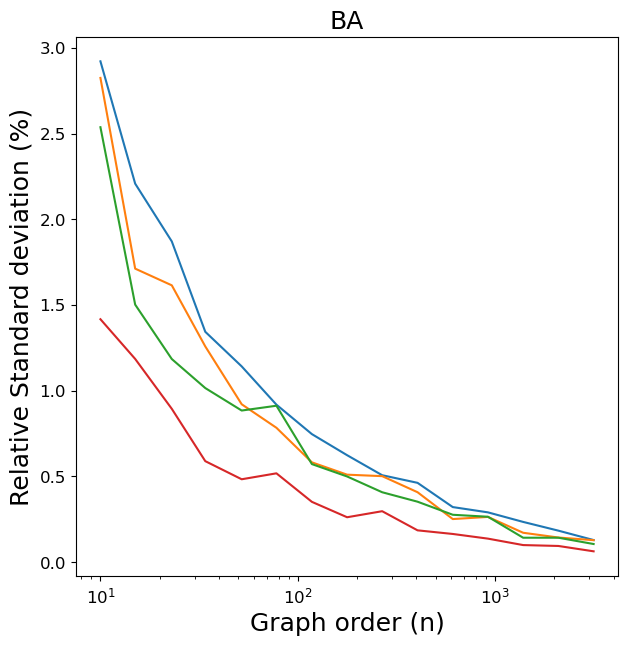

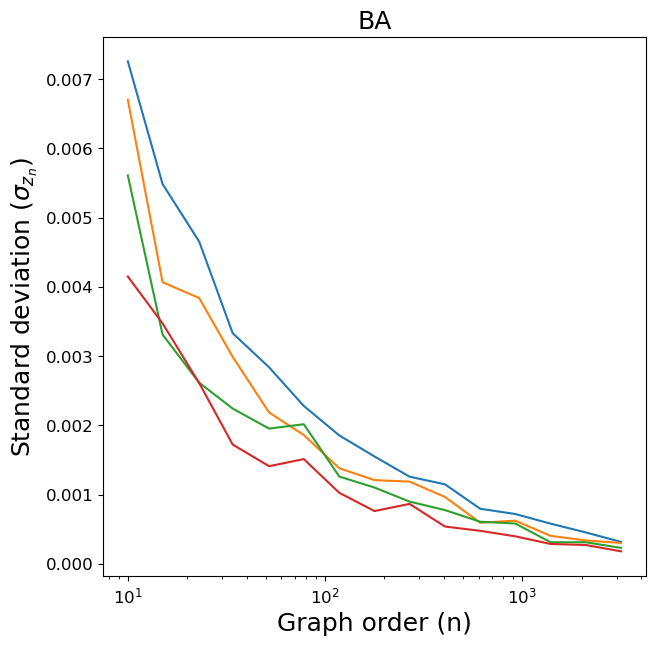

In [318]:
n_values = list(np.round(np.power(10, np.linspace(1,3.5,15))).astype(int))
graph_model_params_list = [('WS', (4,0.5)), ('ER', None), ('BA', 3)]

# time parameter
opt['time'] = 1

# set model
opt['weight'] = False

#t_list = [0.1, 0.5, 1, 1.5, 2]
t_list = [1]
mean_std_densities_list = []

for random_graph_model, random_graph_params in graph_model_params_list:
    for time in t_list:
        opt['time'] = time
        mean_densities_tensor, std_densities_tensor = ConvergenceStudy(n_values, opt, m1_params, m2_params, random_graph_model, random_graph_params)
        print(random_graph_model, f't={time}', '-'*100)
        title = random_graph_model
        visualise_mean_class_probability_and_std(mean_densities_tensor, std_densities_tensor, title)
        
        mean_std_densities_list.append((mean_densities_tensor, std_densities_tensor))

# Weighted CGNN simulations; t=1

[10, 15, 23, 34, 52, 78, 118, 178, 268, 405, 611, 921, 1389, 2096, 3162]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:39<00:00, 18.61s/it]


WS t=1 ----------------------------------------------------------------------------------------------------


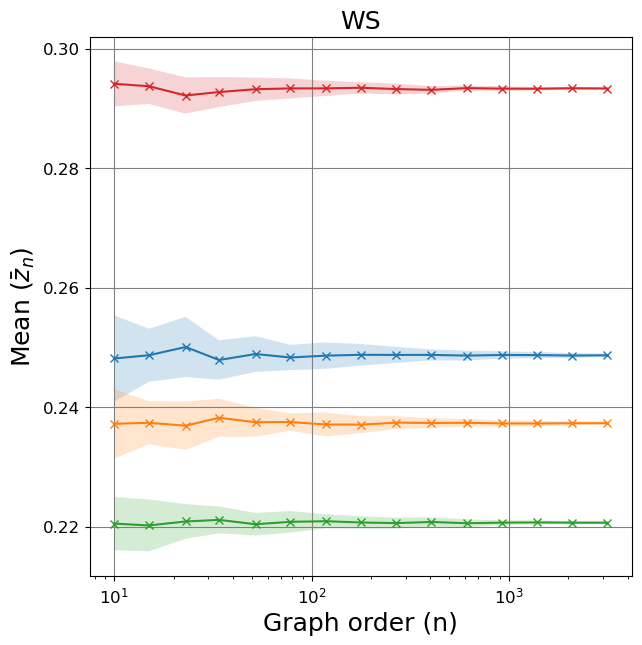

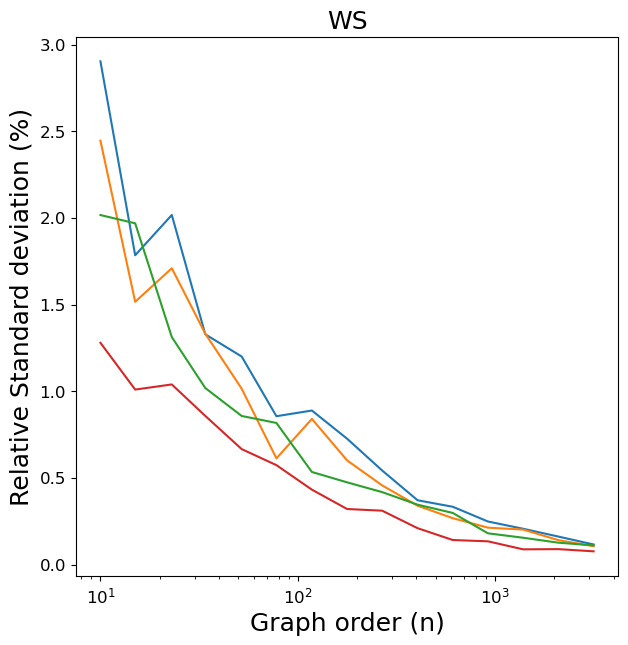

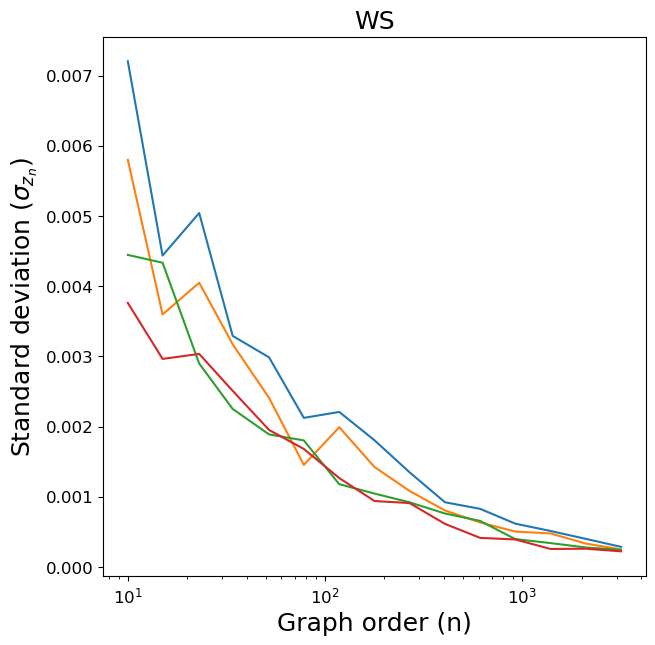

[10, 15, 23, 34, 52, 78, 118, 178, 268, 405, 611, 921, 1389, 2096, 3162]


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]C:\Users\prane\AppData\Local\Temp\ipykernel_16672\3406047335.py:28: RuntimeWarning: divide by zero encountered in divide
  d_inv_sqrt = 1 / np.sqrt(degrees)
100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [07:07<00:00, 28.48s/it]


ER t=1 ----------------------------------------------------------------------------------------------------


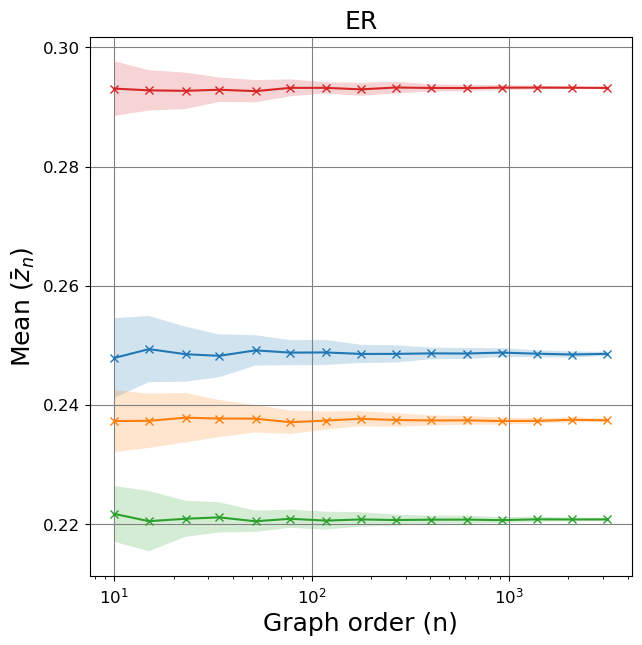

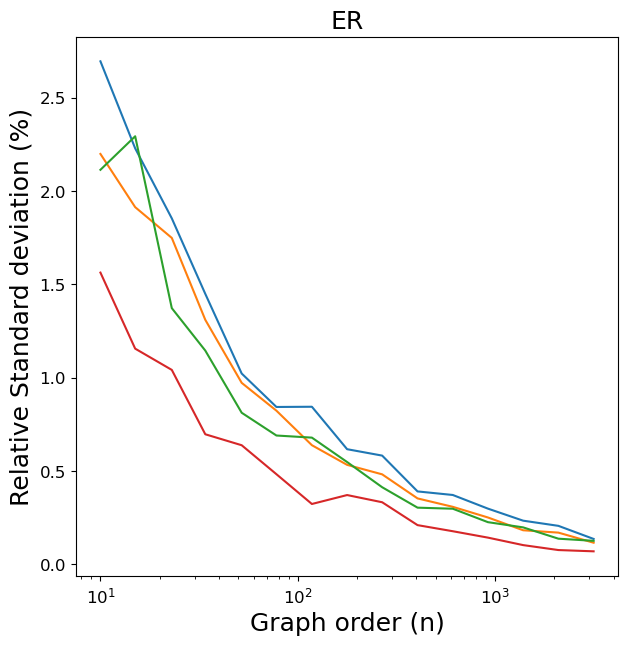

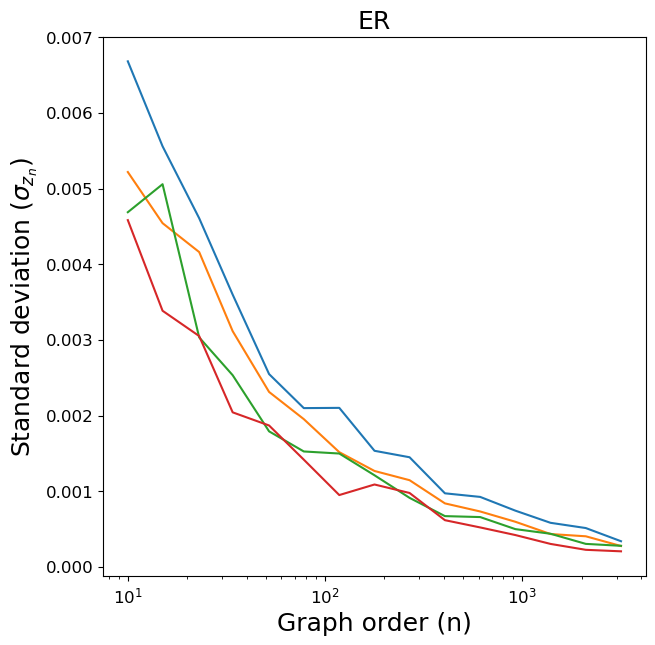

[10, 15, 23, 34, 52, 78, 118, 178, 268, 405, 611, 921, 1389, 2096, 3162]


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:11<00:00, 24.76s/it]


BA t=1 ----------------------------------------------------------------------------------------------------


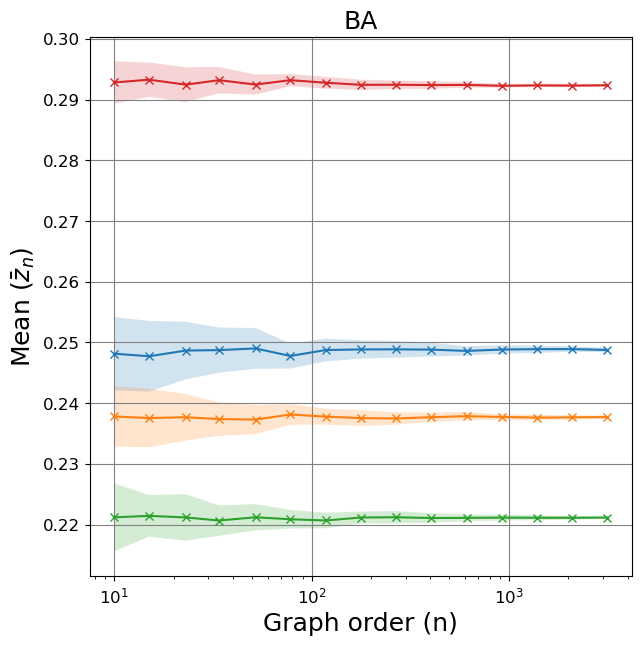

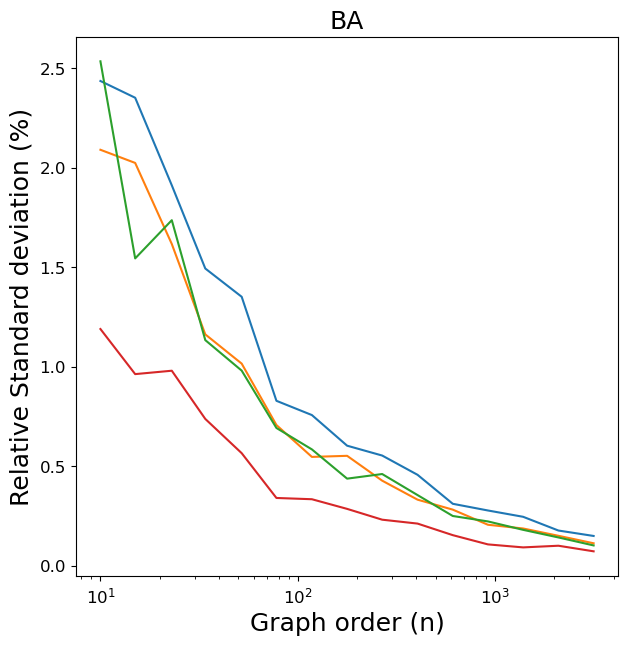

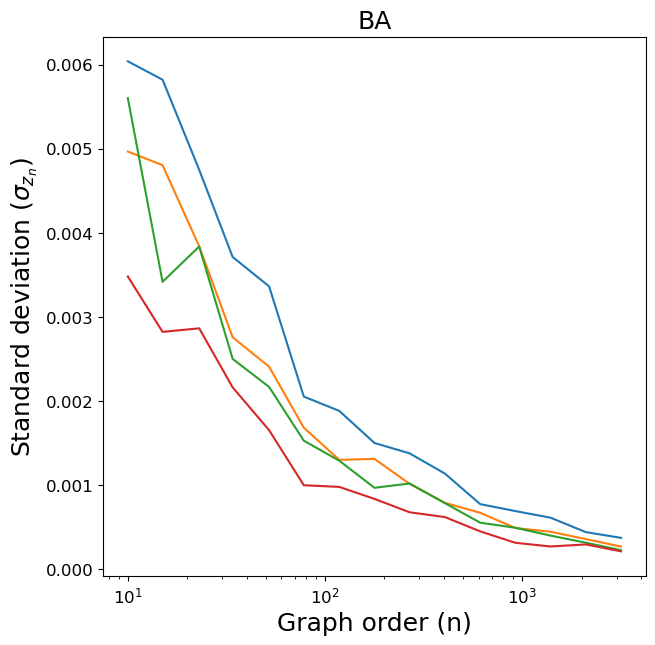

In [319]:
n_values = list(np.round(np.power(10, np.linspace(1,3.5,15))).astype(int))
graph_model_params_list = [('WS', (4,0.5)), ('ER', None), ('BA', 3)]

# set model
opt['weight'] = True

t_list = [1]

for random_graph_model, random_graph_params in graph_model_params_list:
    for time in t_list:
        opt['time'] = time
        mean_densities_tensor, std_densities_tensor = ConvergenceStudy(n_values, opt, m1_params, m2_params, random_graph_model, random_graph_params)
        print(random_graph_model, f't={time}', '-'*100)
        title = random_graph_model
        visualise_mean_class_probability_and_std(mean_densities_tensor, std_densities_tensor, title)
        
        mean_std_densities_list.append((mean_densities_tensor, std_densities_tensor))

# Average std across all 6 simulations; t=1

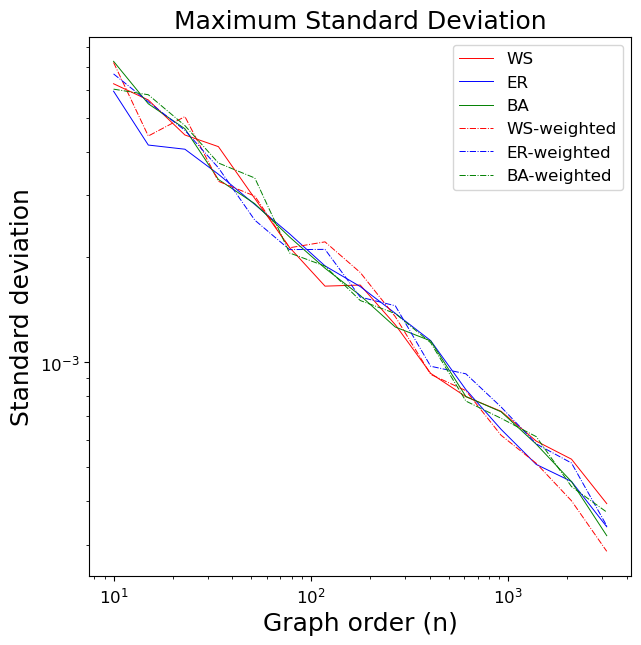

In [422]:
std_densities_list = [x[1] for x in mean_std_densities_list]
label_list = ['WS', 'ER', 'BA', 'WS-weighted', 'ER-weighted', 'BA-weighted']
n_values = list(np.round(np.power(10, np.linspace(1,3.5,15))).astype(int))

plt.figure(figsize=(7, 7))


# Add labels and legend
plt.xlabel('Graph order (n)')
plt.ylabel('Standard deviation')

plt.xscale('log')
plt.yscale('log')

plt.title('Maximum Standard Deviation')

cols=['r', 'b', 'g', 'r', 'b', 'g']


for i in range(6):
    mean_stds = std_densities_list[i].max(axis=1).values
    if i>=3:    
        plt.plot(n_values, mean_stds, label=label_list[i], linewidth=0.7, ls='-.', color=cols[i])
    else:
        plt.plot(n_values, mean_stds, label=label_list[i], linewidth=0.7, ls='-', color=cols[i])

plt.legend()
plt.show()

    

# Varying t

In [408]:
n_values = [10, 100, 1000]
graph_model_params_list = [('ER', None)]

# time parameter

# set model
opt['weight'] = False

#t_list = [0.1, 0.5, 1, 1.5, 2]
t_list = np.linspace(0.01,10,21)
mean_std_densities_list_varying_t = []

for random_graph_model, random_graph_params in graph_model_params_list:
    for time in t_list:
        opt['time'] = time
        mean_densities_tensor, std_densities_tensor = ConvergenceStudy(n_values, opt, m1_params, m2_params, random_graph_model, random_graph_params)
        print(random_graph_model, f't={time}', '-'*100)
        title = random_graph_model
        
        mean_std_densities_list_varying_t.append((mean_densities_tensor, std_densities_tensor))

[10, 100, 1000]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\prane\AppData\Local\Temp\ipykernel_16672\3406047335.py:28: RuntimeWarning: divide by zero encountered in divide
  d_inv_sqrt = 1 / np.sqrt(degrees)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.74s/it]


ER t=0.01 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.94s/it]


ER t=0.5095 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.46s/it]


ER t=1.009 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.23s/it]


ER t=1.5085 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.72s/it]


ER t=2.008 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.51s/it]


ER t=2.5075 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.41s/it]


ER t=3.0069999999999997 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:43<00:00, 14.48s/it]


ER t=3.5065 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:49<00:00, 16.52s/it]


ER t=4.006 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:58<00:00, 19.41s/it]


ER t=4.5055 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:02<00:00, 20.86s/it]


ER t=5.005 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:04<00:00, 21.61s/it]


ER t=5.5045 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:08<00:00, 22.86s/it]


ER t=6.004 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:11<00:00, 23.82s/it]


ER t=6.5035 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:18<00:00, 26.31s/it]


ER t=7.003 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:15<00:00, 25.11s/it]


ER t=7.5024999999999995 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:21<00:00, 27.23s/it]


ER t=8.002 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:18<00:00, 26.06s/it]


ER t=8.5015 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:20<00:00, 26.82s/it]


ER t=9.001 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:15<00:00, 25.31s/it]


ER t=9.5005 ----------------------------------------------------------------------------------------------------
[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:19<00:00, 26.41s/it]

ER t=10.0 ----------------------------------------------------------------------------------------------------


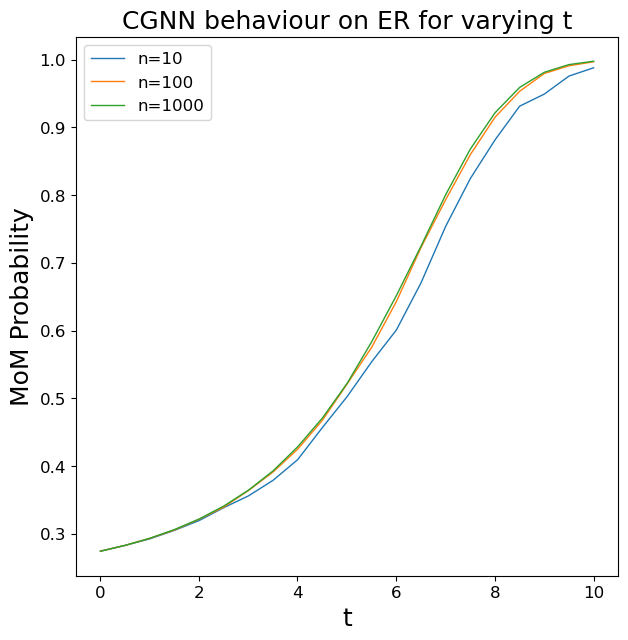

In [425]:
plt.figure(figsize=(7, 7))
n_values = [10, 100, 1000]

mean_densities_list_varying_t = torch.vstack([x[0].max(axis=1).values for x in mean_std_densities_list_varying_t])

# Add labels and legend
plt.xlabel('t')
plt.ylabel('MoM Probability')

plt.title('Effect of time-parameter on CGNN convergence')


for i, n in enumerate(n_values):
    y = mean_densities_list_varying_t[:, i]
    plt.plot(t_list, y,label=f'n={n}', linewidth=1, ls='-')


plt.legend()
plt.show()


# Extra plots

[10, 100, 1000]


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\Users\prane\AppData\Local\Temp\ipykernel_16672\3406047335.py:28: RuntimeWarning: divide by zero encountered in divide
  d_inv_sqrt = 1 / np.sqrt(degrees)
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:10<00:00,  3.66s/it]


ER t=0.01 ----------------------------------------------------------------------------------------------------


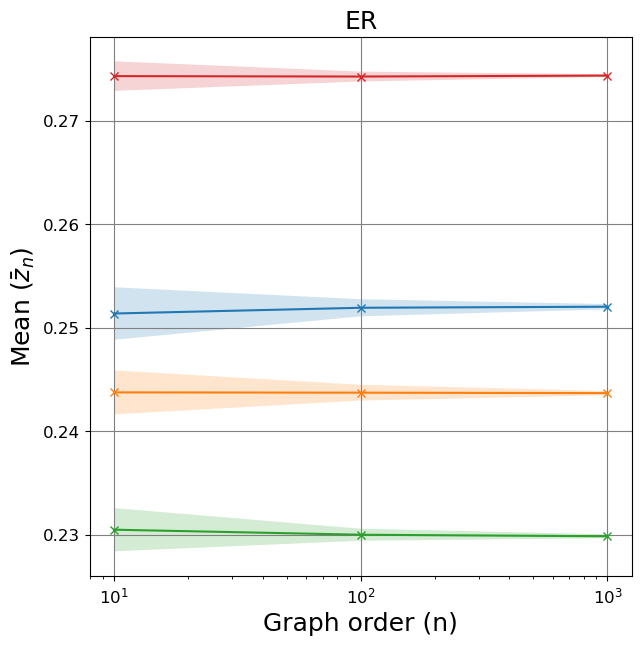

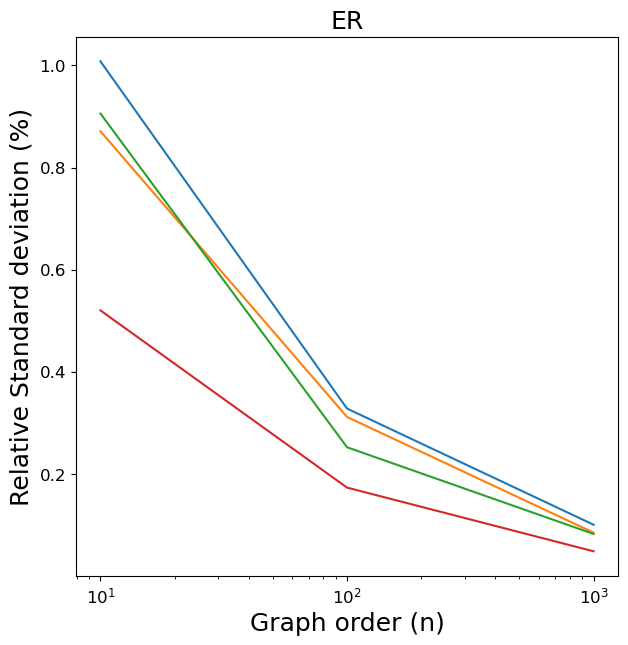

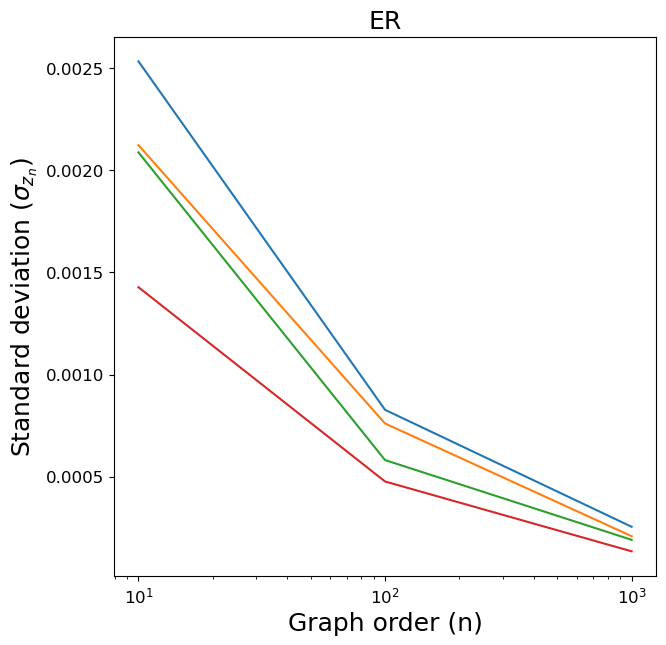

[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:37<00:00, 12.41s/it]


ER t=5.005 ----------------------------------------------------------------------------------------------------


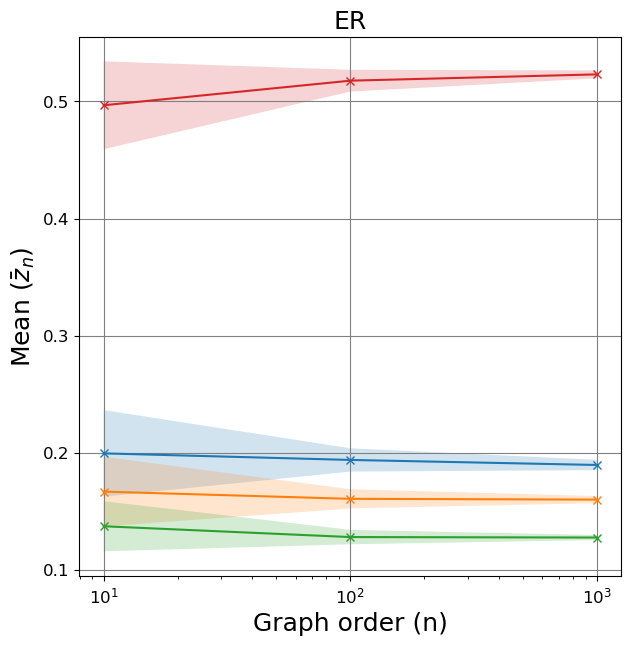

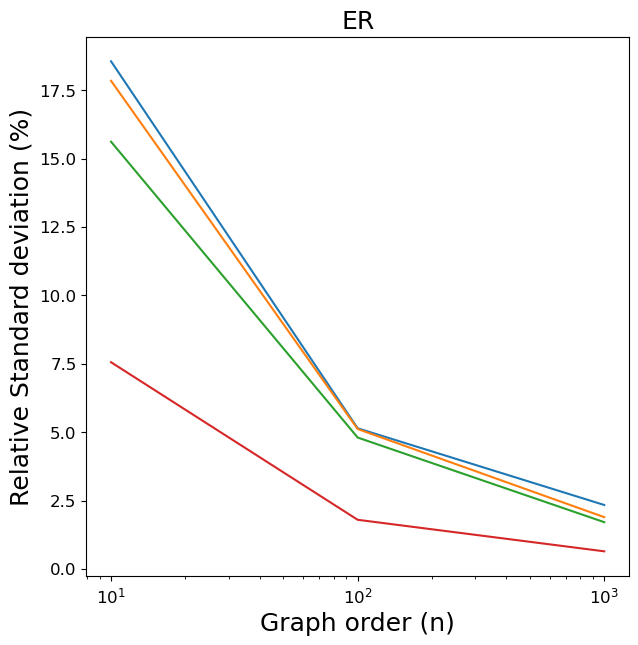

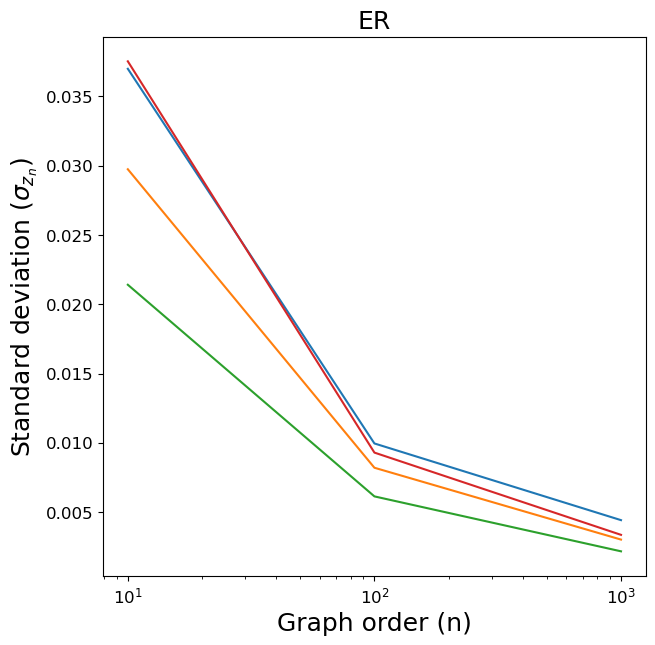

[10, 100, 1000]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.01s/it]


ER t=10.0 ----------------------------------------------------------------------------------------------------


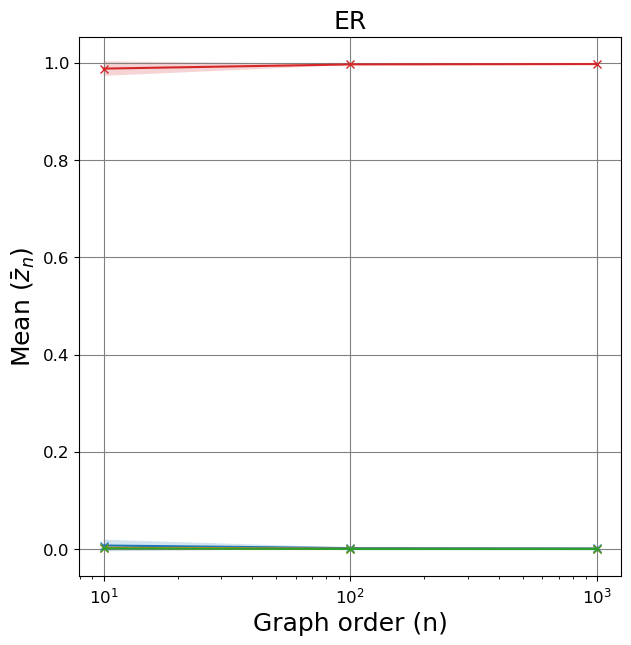

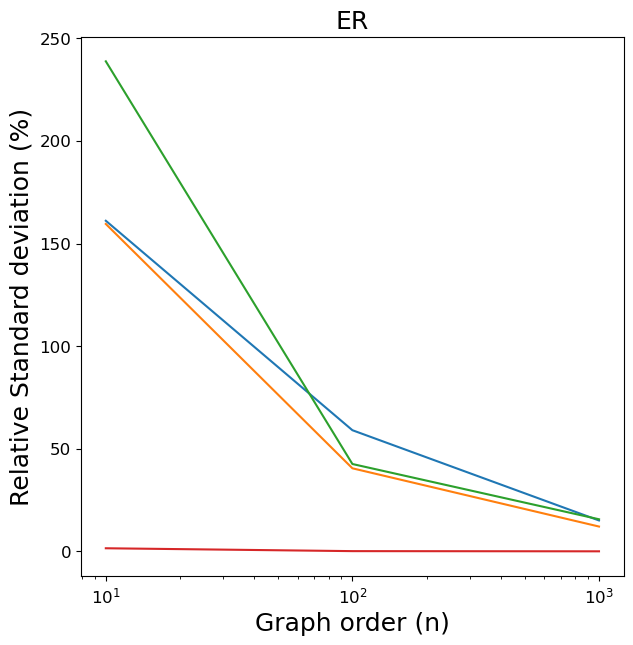

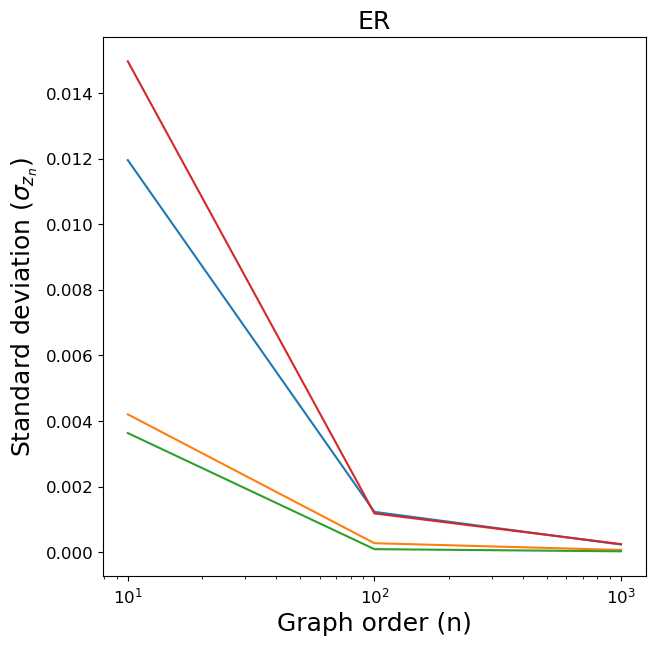

In [426]:
n_values = [10, 100, 1000]
graph_model_params_list = [('ER', None)]

# time parameter

# set model
opt['weight'] = False

#t_list = [0.1, 0.5, 1, 1.5, 2]
t_list = np.linspace(0.01,10,3)
mean_std_densities_list_varying_t = []

for random_graph_model, random_graph_params in graph_model_params_list:
    for time in t_list:
        opt['time'] = time
        mean_densities_tensor, std_densities_tensor = ConvergenceStudy(n_values, opt, m1_params, m2_params, random_graph_model, random_graph_params)
        print(random_graph_model, f't={time}', '-'*100)
        title = 'ER'
        visualise_mean_class_probability_and_std(mean_densities_tensor, std_densities_tensor, title)

        
        mean_std_densities_list_varying_t.append((mean_densities_tensor, std_densities_tensor))

[10, 14, 21, 30, 43, 62, 89, 127, 183, 264, 379, 546, 785, 1129, 1624, 2336, 3360, 4833, 6952, 10000]


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:40:02<00:00, 300.11s/it]


WS ----------------------------------------------------------------------------------------------------


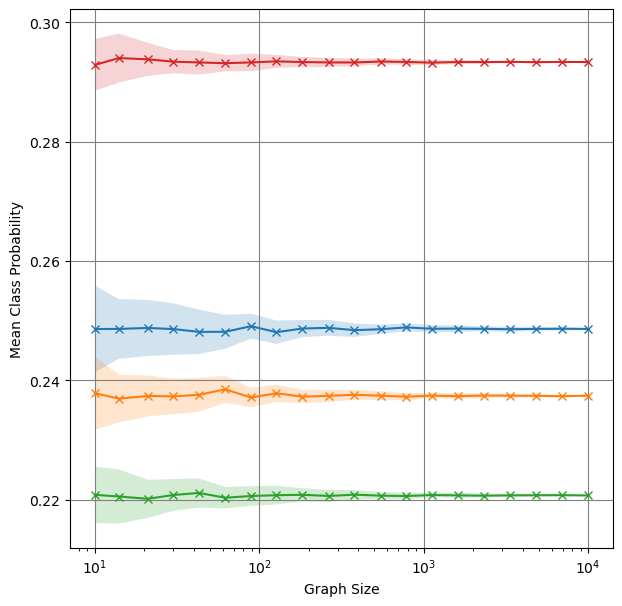

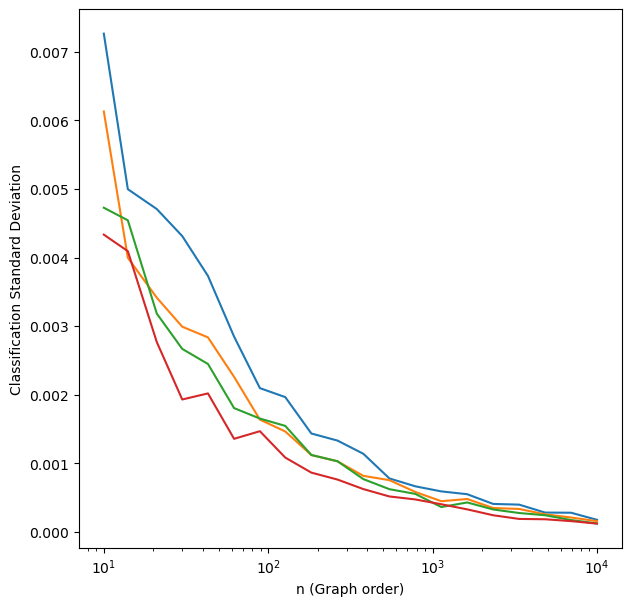

[10, 14, 21, 30, 43, 62, 89, 127, 183, 264, 379, 546, 785, 1129, 1624, 2336, 3360, 4833, 6952, 10000]


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\prane\AppData\Local\Temp\ipykernel_16672\3406047335.py:28: RuntimeWarning: divide by zero encountered in divide
  d_inv_sqrt = 1 / np.sqrt(degrees)
100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:51:22<00:00, 334.12s/it]


ER ----------------------------------------------------------------------------------------------------


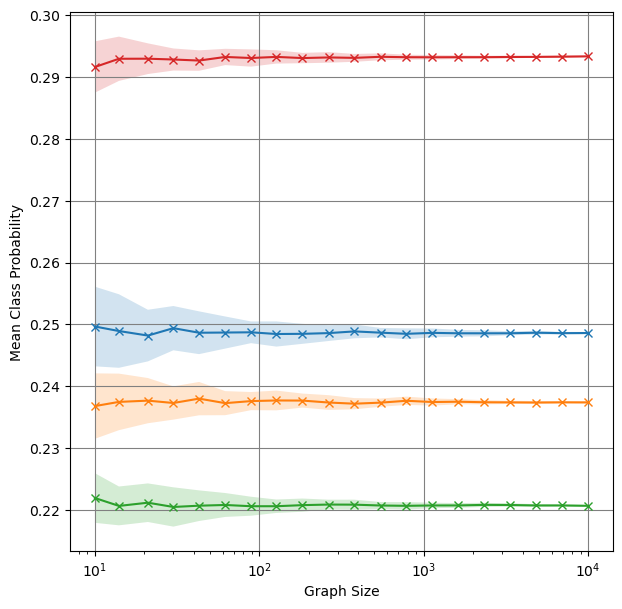

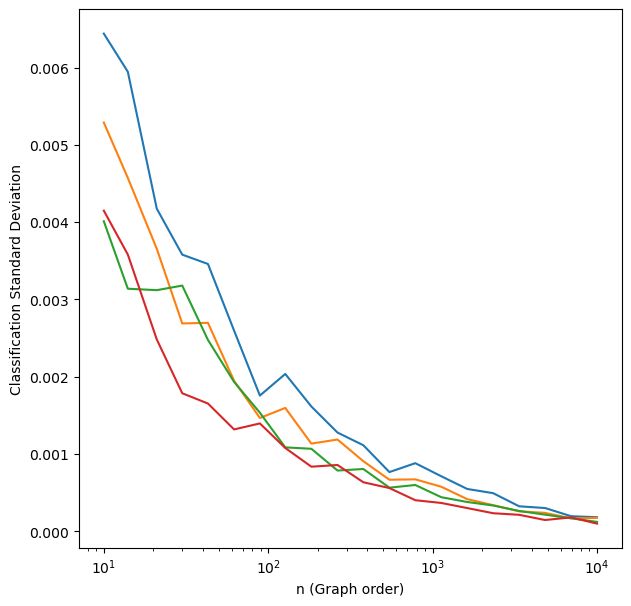

[10, 14, 21, 30, 43, 62, 89, 127, 183, 264, 379, 546, 785, 1129, 1624, 2336, 3360, 4833, 6952, 10000]


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:38:26<00:00, 295.33s/it]


BA ----------------------------------------------------------------------------------------------------


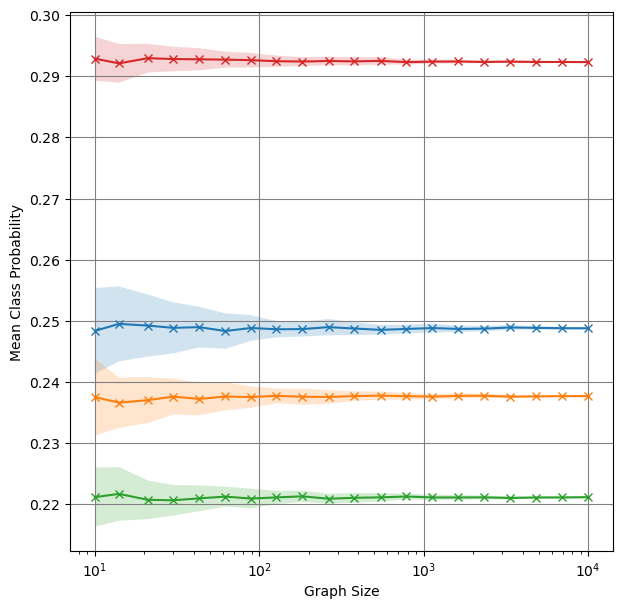

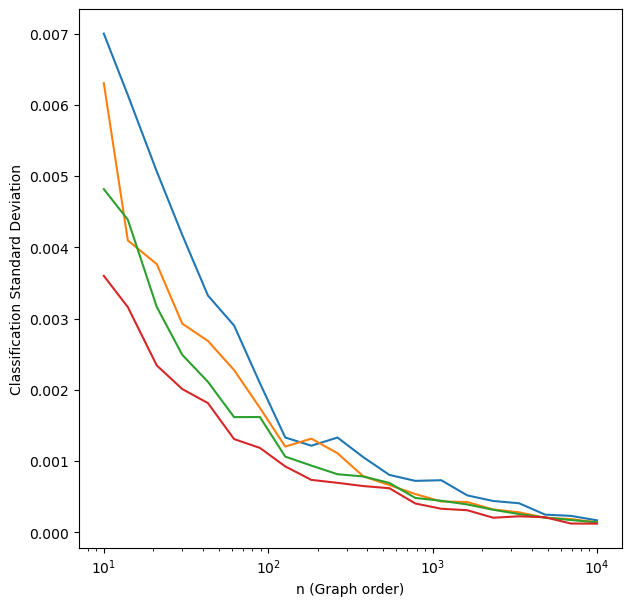

In [280]:
n_values = list(np.round(np.power(10, np.linspace(1,4,20))).astype(int))
random_graph_model, random_graph_params = 'BA', 3

graph_model_params_list = [('WS', (3,0.2)), ('ER', None), ('BA', 3)]
opt['time'] = 1

for random_graph_model, random_graph_params in graph_model_params_list:
    mean_densities_tensor, std_densities_tensor = ConvergenceStudy(n_values, opt, m1_params, m2_params, random_graph_model, random_graph_params)
    print(random_graph_model, '-'*100)
    visualise_mean_class_probability_and_std(mean_densities_tensor, std_densities_tensor)

array([ 0.01 ,  1.009,  2.008,  3.007,  4.006,  5.005,  6.004,  7.003,
        8.002,  9.001, 10.   ])

In [307]:
std_densities_tensor

tensor([[2.7954e-01, 4.4628e-01, 4.6878e-01, 5.6257e-08],
        [1.7087e-01, 4.0501e-01, 4.0701e-01, 8.4020e-10],
        [1.4362e-01, 3.9019e-01, 3.9587e-01, 3.6959e-10],
        [1.4197e-02, 2.9789e-01, 2.9873e-01, 3.7001e-10],
        [1.0901e-02, 2.3772e-01, 2.3804e-01, 6.1080e-10],
        [4.7940e-03, 2.1657e-01, 2.1652e-01, 1.1765e-10],
        [4.1852e-03, 1.4845e-01, 1.4997e-01, 7.0141e-11],
        [4.8773e-03, 1.5074e-01, 1.5322e-01, 8.5620e-11],
        [3.2858e-03, 1.1348e-01, 1.1386e-01, 5.4589e-11],
        [2.6880e-03, 1.1679e-01, 1.1766e-01, 4.7323e-11],
        [2.6412e-03, 1.0028e-01, 1.0143e-01, 4.2919e-11]])

In [292]:
std_dist

tensor([3.7683e-03, 1.9226e-01, 1.9187e-01, 8.6956e-11])

In [110]:
mean_dist

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [111]:
std_dist

tensor([0., 0., 0., 0.])

In [112]:
mean_dist

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [113]:
list(range(50,500,50))

[50, 100, 150, 200, 250, 300, 350, 400, 450]